<br><br>
# Case 2: Diabetic retinopathy

### Juha Nuutinen

### 01.03.2019

### Helsinki Metropolia University of Applied Sciences
<br><br>

# 1. Objectives
This notebook documents the process of using a convolutional neural network to detect the presence of diabetic retinopathy from images of the back of the eye (fundus photography). The goal for this assignment is to learn to use convolutional neural networks to classify medical images.

# 2. Required Libraries

In [18]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models

%matplotlib inline

from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import accuracy_score, roc_curve

# 3. Data

### Origin

In 2015, California Health Foundation together with eyePacs announced the open [Kaggle competition for detecting diabetic retinopathy](https://www.kaggle.com/c/diabetic-retinopathy-detection). The competition opened a very large dataset of [fundus photography](https://en.wikipedia.org/wiki/Fundus_photography), provided by eyePacs. For this assignment, a [curated and smaller dataset](https://github.com/Nomikxyz/retinopathy-dataset) derived from the original is used.

### Description

The dataset contains a total of 2062 color JPEG images, and is about 2.1 GB in size. The images are rather large, with height and width varying between 2000-5000 pixels. They are divided into two directories: <i>symptoms</i> and <i>nosymptoms</i>.

### Preprocessing

#### Data splitting
keras' `ImageDataGenerator` will be used to handle the feeding of image batches for training the model. Loading all the training images to memory would not be possible on my machine. The first step is to create a directory structure as follows:

```
case_2/
    nuutinen_case_2_retinopathy.ipynb
    Week 4. Create directories.ipynb
    retinopathy-dataset-master/
        nosymptoms/
        symptoms/
    dataset2/
        test/
            nosymptoms/
            symptoms/
        train/
            nosymptoms/
            symptoms/
        validation/
            nosymptoms/
            symptoms/
```
The notebook `Week 4. Create directories.ipynb` (by Sakari Lukkarinen & Juha Kopu, [Helsinki Metropolia University of Applied Sciences](http://metropolia.fi/en)) handles the creation of the above directory structure, splitting the data into training (50%), validation (25%) and test (25%) sets, and copying them to the corresponding directories. When the data is split into directories, using the image generators becomes very straight forward. The data splitting is done using scikit-learn's `train_test_split` function.

From now on, it is assumed that all the code in `Week 4. Create directories.ipynb` has been run, i.e. the above directory structure exists and the images have been copied to correspondig directories. The directory and file manipulation code is kept in a separate notebook for the sake of brevity.

#### Creating the image generators
The code cell below is a modified excerpt from Lukkarinen's and Kopu's notebook [here](https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week%204.%20Case%202%20-%20First%20trial.ipynb).

The following cell also defines the augmentations for the training and validation data.

In [2]:
train_dir = "./dataset2/train"
validation_dir = "./dataset2/validation"

# Zoom, rotation and shear for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    rotation_range=360,
    shear_range=0.2)

# Only rotation for validation data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360)

print("Training set: ", end='')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary')

print("Validation set: ", end='')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary')

Training set: Found 1031 images belonging to 2 classes.
Validation set: Found 516 images belonging to 2 classes.


# 4. Modeling and compilation

In [3]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(52, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(layers.Conv2D(52, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(52, (3, 3), activation='relu'))
    model.add(layers.Conv2D(52, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

def load_model(name):
    return models.load_model(name)

model = create_model()
#model = load_model("case_2_78_val_acc.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 52)      1456      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 52)      24388     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 52)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 52)      24388     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 52)      24388     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 52)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 193492)            0         
__________

# 5. Training and and validation

In [4]:
# Go through all the training & validation images
# in every epoch
steps = train_generator.n // train_generator.batch_size
steps_validation = validation_generator.n // validation_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps,
    verbose = 1,
    epochs = 72,
    validation_data = validation_generator,
    validation_steps = steps_validation,
    workers=4
)

model.save('case_2_run_2.h5')

Epoch 1/72
64/64 [==============================] - 631s 10s/step - loss: 0.6093 - acc: 0.6938 - val_loss: 0.5160 - val_acc: 0.7109
Epoch 2/72
64/64 [==============================] - 620s 10s/step - loss: 0.5702 - acc: 0.7121 - val_loss: 0.5497 - val_acc: 0.7200
Epoch 3/72
64/64 [==============================] - 634s 10s/step - loss: 0.5365 - acc: 0.7179 - val_loss: 0.5654 - val_acc: 0.7080
Epoch 4/72
64/64 [==============================] - 599s 9s/step - loss: 0.5378 - acc: 0.7043 - val_loss: 0.4946 - val_acc: 0.7140
Epoch 5/72
64/64 [==============================] - 609s 10s/step - loss: 0.5292 - acc: 0.7084 - val_loss: 0.5901 - val_acc: 0.6960
Epoch 6/72
64/64 [==============================] - 629s 10s/step - loss: 0.5533 - acc: 0.7130 - val_loss: 0.5404 - val_acc: 0.7280
Epoch 7/72
64/64 [==============================] - 635s 10s/step - loss: 0.5324 - acc: 0.7065 - val_loss: 0.5071 - val_acc: 0.6940
Epoch 8/72
64/64 [==============================] - 616s 10s/step - loss: 0.5

64/64 [==============================] - 576s 9s/step - loss: 0.4795 - acc: 0.7754 - val_loss: 0.4917 - val_acc: 0.7700
Epoch 64/72
64/64 [==============================] - 574s 9s/step - loss: 0.4765 - acc: 0.7758 - val_loss: 0.4940 - val_acc: 0.7720
Epoch 65/72
64/64 [==============================] - 574s 9s/step - loss: 0.4611 - acc: 0.7702 - val_loss: 0.4797 - val_acc: 0.7480
Epoch 66/72
64/64 [==============================] - 568s 9s/step - loss: 0.4713 - acc: 0.7819 - val_loss: 0.5006 - val_acc: 0.7560
Epoch 67/72
64/64 [==============================] - 579s 9s/step - loss: 0.4614 - acc: 0.7846 - val_loss: 0.4788 - val_acc: 0.7715
Epoch 68/72
64/64 [==============================] - 577s 9s/step - loss: 0.4762 - acc: 0.7741 - val_loss: 0.4889 - val_acc: 0.7680
Epoch 69/72
64/64 [==============================] - 578s 9s/step - loss: 0.4743 - acc: 0.7731 - val_loss: 0.4668 - val_acc: 0.7760
Epoch 70/72
64/64 [==============================] - 577s 9s/step - loss: 0.4668 - acc: 

# 6. Results
## Validation and training results
### Training and validation accuracy & loss during training

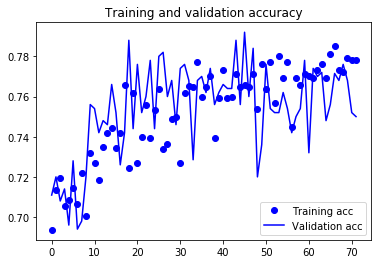

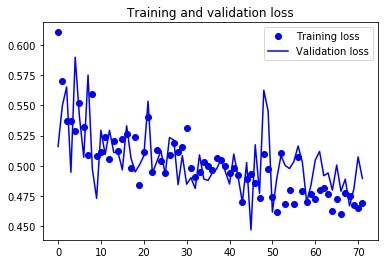

In [5]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

On my machine, the biggest bottle neck in training of the neural network was the CPU, and then the HDD. Using these `ImageDataGenerator`s that read images from the hard drive, the GPU does not really contribute that much to the training speed. Instead the most time consuming process is reading the images to memory and applying augmentation to them; tweaking the network's weights doesn't take that much time in comparison. That meant I did not get that many tries to tune the network, due to time constraints.

The model saved as `case_2_run_1.h5` was trained for about 16 hours, and it had a final validation accuracy varying between 0,78 and 0,80. Unfortunately I forgot to run the graphing cells before closing jupyter notebook, and so I lost track of the `History` object, meaning I could not save the graphs.

So the model above (`case_2_run_2.h5`), is a worse performing one, than the previous one.
### Training and validation metrics

In [6]:
# Calculate the true and predicted values
y_true = validation_generator.classes
predict = model.predict_generator(validation_generator)
y_pred = predict > 0.5

In [22]:
# Calculate and print the metrics results

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(y_true, y_pred)
print('Classification report:')
print(cr)
print('')

a = accuracy_score(y_true, predict > 0.5)
print('Accuracy with decision point {:.4f} ==> {:.4f}'.format(0.5, a))

Confusion matrix:
[[277  90]
 [111  38]]

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       367
           1       0.30      0.26      0.27       149

   micro avg       0.61      0.61      0.61       516
   macro avg       0.51      0.50      0.50       516
weighted avg       0.59      0.61      0.60       516


Accuracy with decision point 0.5000 ==> 0.6105


As the confusion matrix suggests, this model is very poor. There's way more false negatives than true positives, meaning most of the disease cases were labeled as healthy. The low precision (0,30) and recall (0,26) also indicate this. Using class weights, a longer training period, and more finely tuned network would have probably yielded better results.

The decision point can be altered, but as shown below, the overall results remain bad.

In [21]:
dp = 0.25
cm = confusion_matrix(y_true, predict > dp)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(y_true, predict > dp)
print('Classification report:')
print(cr)
print('')

a = accuracy_score(y_true, predict > dp)
print('Accuracy with decision point {:.4f} ==> {:.4f}'.format(dp, a))

Confusion matrix:
[[178 189]
 [ 80  69]]

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.49      0.57       367
           1       0.27      0.46      0.34       149

   micro avg       0.48      0.48      0.48       516
   macro avg       0.48      0.47      0.45       516
weighted avg       0.57      0.48      0.50       516


Accuracy with decision point 0.2500 ==> 0.4787


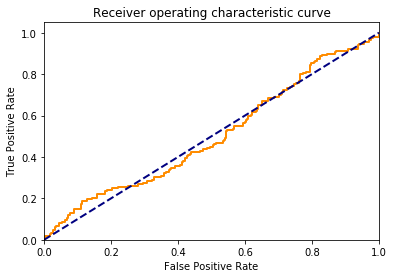

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predict)

plt.plot(fpr, tpr, color='darkorange', lw = 2)
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show()

The ROC-curve tells the same story as the other metrics.
## Final test set results
Finally, lets test the model on the reserved test set (25% of all original images).
### case_2_run_2.h5 (the one displayed above)

In [25]:
test_dir = "./dataset2/test"

final_test_datagen = ImageDataGenerator(rescale=1./255)

print("Test set: ", end='')
test_generator = final_test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary')

y_test_true = test_generator.classes
test_predict = model.predict_generator(test_generator)
y_test_pred = test_predict > 0.5

test_cm = confusion_matrix(y_test_true, y_test_pred)
print('Test set confusion matrix:')
print(test_cm)
print('')

test_cr = classification_report(y_test_true, y_test_pred)
print('Test set classification report:')
print(test_cr)
print('')

test_a = accuracy_score(y_test_true, test_predict > 0.5)
print('Test set accuracy with decision point {:.4f} ==> {:.4f}'.format(0.5, test_a))

Test set: Found 516 images belonging to 2 classes.
Test set confusion matrix:
[[282  85]
 [120  29]]

Test set classification report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       367
           1       0.25      0.19      0.22       149

   micro avg       0.60      0.60      0.60       516
   macro avg       0.48      0.48      0.48       516
weighted avg       0.57      0.60      0.59       516


Test set accuracy with decision point 0.5000 ==> 0.6027


## case_2_run_1.h5

In [26]:
model = load_model("case_2_run_1.h5")

test_predict = model.predict_generator(test_generator)
y_test_pred = test_predict > 0.5

test_cm = confusion_matrix(y_test_true, y_test_pred)
print('Test set confusion matrix:')
print(test_cm)
print('')

test_cr = classification_report(y_test_true, y_test_pred)
print('Test set classification report:')
print(test_cr)
print('')

test_a = accuracy_score(y_test_true, test_predict > 0.5)
print('Test set accuracy with decision point {:.4f} ==> {:.4f}'.format(0.5, test_a))

Test set confusion matrix:
[[282  85]
 [111  38]]

Test set classification report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       367
           1       0.31      0.26      0.28       149

   micro avg       0.62      0.62      0.62       516
   macro avg       0.51      0.51      0.51       516
weighted avg       0.60      0.62      0.61       516


Test set accuracy with decision point 0.5000 ==> 0.6202


Seems that the previous model I trained (and forgot to print metrics during training), is just a little bit better at finding disease cases, but not significantly.
# 7. Conclusion
Overall, the network's performance is about comparable to guesswork; just say that every image is healthy, and a similar accuracy will be achieved.

Better image preprocessing would probably have improved the results. The winning entry in the Kaggle contest altered the color and croppping of the images, and applied a circular mask to them to make the image features more visible and removing some distortions visible in the edges of the images. Also a longer training time would have been beneficial, because there wasn't yet much or any overfitting present in either of my models, that I trained for 10h+.

It was a shame that I could not properly utilize my GPU, because my CPU bottlenecked the training significantly, because of loading images from the disk.